# Geo-innovation paper

**Tasks**

* Load and understand the data
* Produce a simple linechart with activity / DL activity
* Produce metrics of activity by geography and compare periods

In [1]:
%matplotlib inline

#Some imports
import time
#import xml.etree.ElementTree as etree
from lxml import etree

import feedparser

#Imports
#Key imports are loaded from my profile (see standard_imports.py in src folder).

#Paths

#Paths
top = os.path.dirname(os.getcwd())

#External data (to download the GRID database)
ext_data = os.path.join(top,'data/external')

#Interim data (to place seed etc)
int_data = os.path.join(top,'data/interim')

#Figures
fig_path = os.path.join(top,'reports/figures')

#Models
mod_path = os.path.join(top,'models')


#Get date for saving files
today = datetime.datetime.today()

today_str = "_".join([str(x) for x in [today.day,today.month,today.year]])


# 1. Load data

In [2]:
#Load papers
papers = pd.read_csv(ext_data+'/matched_data/compsci_stats_with_tag.csv')

#Focus on good matches
papers = papers.loc[papers.score>0.99,:]
#Focus on the present
papers = papers.loc[(papers.year<2018) & (papers.year>1990),:]



# 2. Descriptive analysis

In [3]:
papers['citations_norm'] = [x/(2018-y) for x,y in zip(papers.citations,papers.year) ]

In [4]:
#Quantiles
papers.citations.describe()

count    142439.000000
mean         13.066765
std          92.063435
min           0.000000
25%           0.000000
50%           2.000000
75%           9.000000
max       15810.000000
Name: citations, dtype: float64

In [5]:
papers.citations_norm.describe()

count    142439.000000
mean          2.400834
std          12.527303
min           0.000000
25%           0.000000
50%           0.600000
75%           2.000000
max        1130.333333
Name: citations_norm, dtype: float64

In [6]:
papers['citations_high'] = [x>9 for x in papers.citations]
papers['citations_high_norm'] = [x>2 for x in papers.citations_norm]

In [7]:
#Cross tab papers by topic
papers.groupby('topic')['citations_norm'].aggregate(['mean','median'])

,mean,median
topic,,
0,2.128003,0.6
1,4.162549,0.5


In [8]:
#Cross tab papers with high citations normalised
pd.crosstab(papers.citations_high_norm,papers.topic,normalize=1)

topic,0,1
citations_high_norm,,
False,0.771871,0.729491
True,0.228129,0.270509


In [9]:
len(set([x for x in papers.first_tag if 'cs.' in x]))

40

In [10]:
#Want to focus on a small number of areas where DL has become more important (there was a paradigm shift)

100*pd.crosstab(papers.first_tag,papers.topic,normalize=0).sort_values(1,ascending=False)[:10]

topic,0,1
first_tag,,
cs.CV,44.052941,55.947059
cs.CL,57.357057,42.642943
cs.LG,63.225256,36.774744
cs.NE,64.564220,35.435780
stat.ML,67.358916,32.641084
cs.SD,70.000000,30.000000
cs.IR,82.943525,17.056475
stat.CO,84.695557,15.304443
cs.NA,84.820240,15.179760


In [11]:
#Focus on CV, CL, ML, LG
#Areas which were not by definition focused on neural networks (like NE)

selected = ['cs.CV','cs.CL','stat.ML','cs.LG']

papers['selected_topics'] = [x in selected for x in papers.first_tag]

#Crosstab
#Focus on selected papers
papers_selected =papers.loc[papers.selected_topics==True,:]

pd.crosstab(papers_selected.year,papers_selected.topic)

topic,0,1
year,,
1993,4,0
1994,2,2
1995,2,3
1996,8,0
1997,16,3
1998,47,3
1999,84,17
2000,151,20
2001,113,25


In [12]:
len(papers_selected)
np.sum(papers_selected.topic==1)

12979

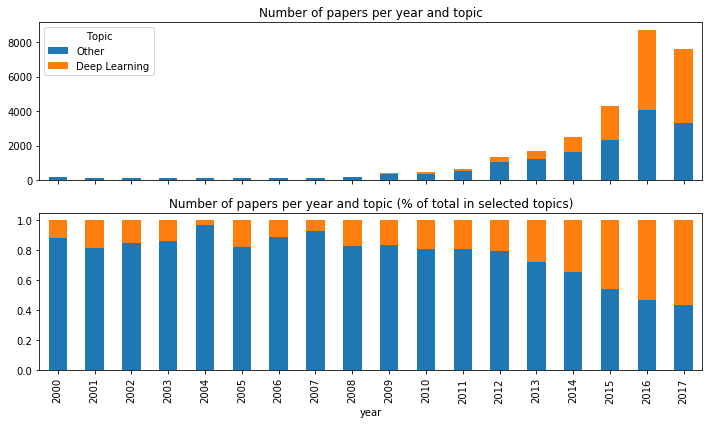

In [13]:
#Simple chart with activity

#Activity
fig,ax = plt.subplots(nrows=2,figsize=(10,6),sharex=True)

year_tots = pd.crosstab(papers_selected.year,papers_selected.topic)

year_tots_recent = year_tots[year_tots.index>=2000]

year_tots_recent.plot.bar(stacked=True,ax=ax[0])

ax[0].legend(labels=['Other','Deep Learning'],title='Topic')
ax[0].set_title("Number of papers per year and topic")


year_props = year_tots_recent.apply(lambda x: x/x.sum(),axis=1)

#Activity

year_props.plot.bar(stacked=True,ax=ax[1])

ax[1].legend(labels=['Other','Deep Learning'],title='Topic')
ax[1].set_title("Number of papers per year and topic (% of total in selected topics)")
ax[1].legend_.remove()

plt.tight_layout()

plt.savefig(fig_path+'/paper_all_papers.pdf')


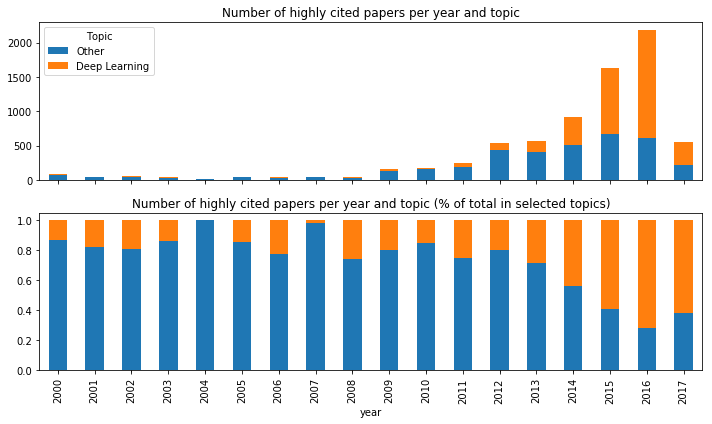

In [14]:
#OK. Let's look at highly cited papers in these domains

highly_cited = papers_selected.loc[(papers_selected.citations_high_norm==True) & 
                                   (papers_selected.year>=2000),:]

fig,ax = plt.subplots(nrows=2,figsize=(10,6),sharex=True)

year_tots_cited = pd.crosstab(highly_cited.year,highly_cited.topic)
year_tots_cited.plot.bar(stacked=True,ax=ax[0])

ax[0].legend(labels=['Other','Deep Learning'],title='Topic')
ax[0].set_title("Number of highly cited papers per year and topic")


year_props_cited = year_tots_cited.apply(lambda x: x/x.sum(),axis=1)

#Activity
year_props_cited.plot.bar(stacked=True,ax=ax[1])

ax[1].legend(labels=['Other','Deep Learning'],title='Topic')
ax[1].set_title("Number of highly cited papers per year and topic (% of total in selected topics)")

ax[1].legend_.remove()

plt.tight_layout()

plt.savefig(fig_path+'/papers_highly_cited.pdf')


There is a sense of revolution from ~ 2014. Lots of papers and lots of highly cited papers

## 3. Competitiveness analysis

Now we will:

* Calculate the competitiveness of different institutes by year. We then subset to focus on top (by total activity) institutes in selected areas




In [15]:
def create_rca(df):
    '''
    Takes a df with cells = activity in col in row and returns a df with cells = rca
    
    '''
    
    area_activity = df.sum(axis=0)
    area_shares = area_activity/area_activity.sum()
    
    rca = df.apply(lambda x: (x/x.sum())/area_shares, axis=1)
    return(rca)




def extract_rca(df,var,year):
    '''
    Takes a df and returns a lq for the year
    
    '''
    
    #Subset
    if var=='pid':
        subset = df.loc[df.year==year,:].groupby(['institute','first_tag'])['pid'].count().reset_index(drop=False)
        
    if var=='citations_high_norm':
        subset = df.loc[df.year==year,:].groupby([
            'institute','first_tag'])[var].sum().reset_index(drop=False)
    
    #Pivot to get rca
    pivoted = pd.pivot_table(subset,index='institute',columns='first_tag',values=var)
    pivoted.fillna(0,inplace=True)
    
    #rca
    rca = create_rca(pivoted)
    rca['year']=year
    
    return(rca)
    



In [16]:
rca_papers = pd.concat([extract_rca(
    papers,'pid',y) for y in np.arange(2005,2018)]).reset_index(drop=False)
rca_citations = pd.concat([extract_rca(
    papers,'citations_high_norm',y) for y in np.arange(2005,2018)]).reset_index(drop=False)

In [17]:
my_orgs = papers['institute'].value_counts().sort_values(ascending=False)[:100].index

rca_papers = rca_papers.loc[[
    x in my_orgs for x in rca_papers.institute],['institute','year']+selected].reset_index(drop=True)

rca_papers['period'] = ['2005_12' if x <2012 else '2012_17' for x in rca_papers.year]

rca_papers_averaged = pd.melt(rca_papers.drop(
    'year',axis=1),id_vars=['institute','period']).groupby(
    ['institute','period','variable'])['value'].mean().reset_index(drop=False)

rca_2005_12 =pd.pivot_table(rca_papers_averaged.loc[rca_papers_averaged.period=='2005_12',:],
                            index='institute',columns='variable',values='value')

rca_2005_12.corr()

variable,cs.CL,cs.CV,cs.LG,stat.ML
variable,,,,
cs.CL,1.000000,0.127596,0.085004,0.031617
cs.CV,0.127596,1.000000,-0.031111,0.080352
cs.LG,0.085004,-0.031111,1.000000,0.135156
stat.ML,0.031617,0.080352,0.135156,1.000000


In [18]:
#This is already quite interesting. Convergence in specialisations
rca_2012_17 =pd.pivot_table(rca_papers_averaged.loc[rca_papers_averaged.period=='2012_17',:],
                            index='institute',columns='variable',values='value')

rca_2012_17.corr()

variable,cs.CL,cs.CV,cs.LG,stat.ML
variable,,,,
cs.CL,1.000000,0.172535,0.188696,0.268237
cs.CV,0.172535,1.000000,0.198476,0.055372
cs.LG,0.188696,0.198476,1.000000,0.363375
stat.ML,0.268237,0.055372,0.363375,1.000000


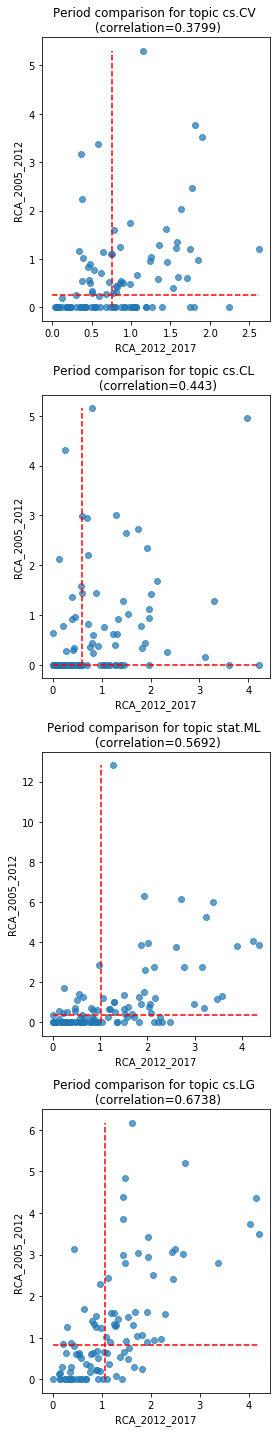

In [19]:
#Create scatters

rca_papers_averaged_wide = pd.pivot_table(rca_papers_averaged,
                                         index=['institute','variable'],
                                          columns='period',values='value').reset_index(drop=False)

fig,ax = plt.subplots(nrows=4,figsize=(4,20))

for num,x in enumerate(set(rca_papers_averaged_wide.variable)):
    subset = rca_papers_averaged_wide.loc[rca_papers_averaged_wide.variable==x,:]
    
    ax[num].scatter(subset['2012_17'],subset['2005_12'],alpha=0.7)
    
    corr = np.round(subset['2012_17'].corr(subset['2005_12'],method='spearman'),4)
    
    ax[num].set_title('Period comparison for topic {x} \n (correlation={corr})'.format(x=x,corr=corr))
    
    ax[num].set_xlabel('RCA_2012_2017')
    ax[num].set_ylabel('RCA_2005_2012')
    

    
    ax[num].hlines(y=np.median(subset['2005_12']),xmin=0,xmax=np.max(subset['2012_17']),color='red',linestyle='dashed')
    ax[num].vlines(x=np.median(subset['2012_17']),ymin=0,ymax=np.max(subset['2005_12']),color='red',linestyle='dashed')
    

plt.tight_layout()

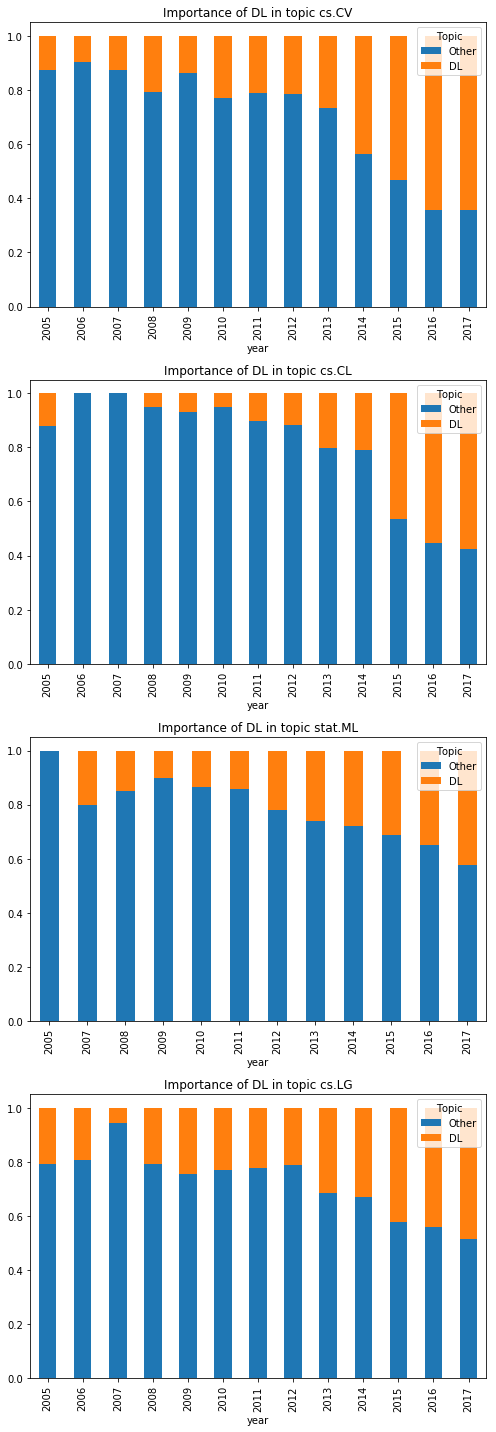

In [20]:
#Produce charts of DL adoption by area

papers_plot = papers_selected.loc[papers_selected[
    'year']>2004].groupby(['year','topic','first_tag'])['pid'].count().reset_index(drop=False)

fig,ax = plt.subplots(nrows=4,figsize=(7,20))

for num,x in enumerate(set(papers_plot['first_tag'])):
    #Subset
    subset = papers_plot.loc[papers_plot.first_tag==x,:]
    
    #Pivot
    pivoted = pd.pivot_table(subset,index='year',columns='topic',values='pid')
    pivoted_props = pivoted.apply(lambda x: x/x.sum(),axis=1)
    
    pivoted_props.plot.bar(stacked=True,ax=ax[num])
    
    ax[num].set_title("Importance of DL in topic {x}".format(x=x))
    ax[num].legend(labels=['Other','DL'],title='Topic')
    
plt.tight_layout()



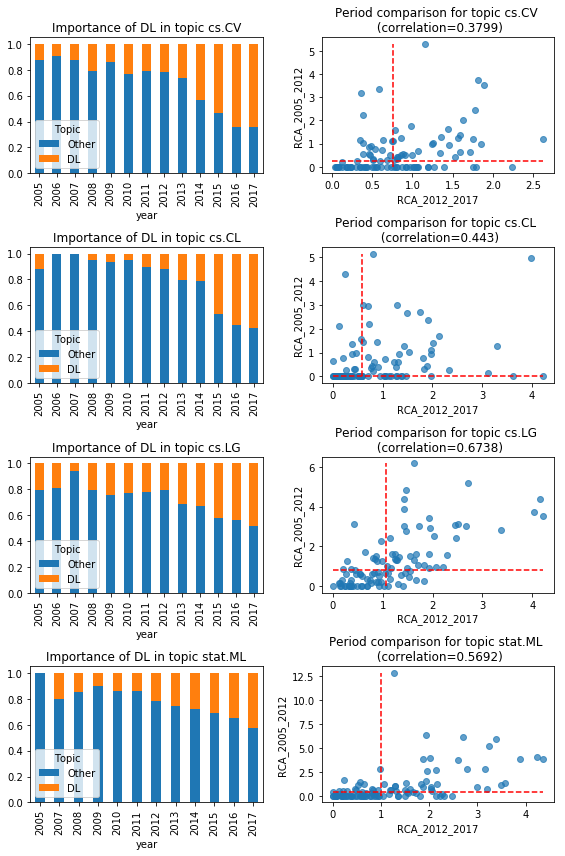

In [21]:
#Put everything together in a single chart

fig,ax = plt.subplots(nrows=4,ncols=2,figsize=(8,12))

topics_sorted = ['cs.CV','cs.CL','cs.LG','stat.ML']

for num,x in enumerate(topics_sorted):
    subset = rca_papers_averaged_wide.loc[rca_papers_averaged_wide.variable==x,:]
    
    ax[num,1].scatter(subset['2012_17'],subset['2005_12'],alpha=0.7)
    
    corr = np.round(subset['2012_17'].corr(subset['2005_12'],method='spearman'),4)
    
    ax[num,1].set_title('Period comparison for topic {x} \n (correlation={corr})'.format(x=x,corr=corr))
    
    ax[num,1].set_xlabel('RCA_2012_2017')
    ax[num,1].set_ylabel('RCA_2005_2012')
    

    
    ax[num,1].hlines(y=np.median(subset['2005_12']),xmin=0,xmax=np.max(subset['2012_17']),color='red',linestyle='dashed')
    ax[num,1].vlines(x=np.median(subset['2012_17']),ymin=0,ymax=np.max(subset['2005_12']),color='red',linestyle='dashed')
    
    #Subset
    subset = papers_plot.loc[papers_plot.first_tag==x,:]
    
    #Pivot
    pivoted = pd.pivot_table(subset,index='year',columns='topic',values='pid')
    pivoted_props = pivoted.apply(lambda x: x/x.sum(),axis=1)
    
    pivoted_props.plot.bar(stacked=True,ax=ax[num,0])
    
    ax[num,0].set_title("Importance of DL in topic {x}".format(x=x))
    ax[num,0].legend(labels=['Other','DL'],title='Topic',loc=3)
    

    
plt.tight_layout()

#fig.suptitle('Levels of DL activity and changes in performance before and after DL break \n (by research category)',
#             fontsize=14)
    


plt.savefig(fig_path+'/activity_plots.pdf')


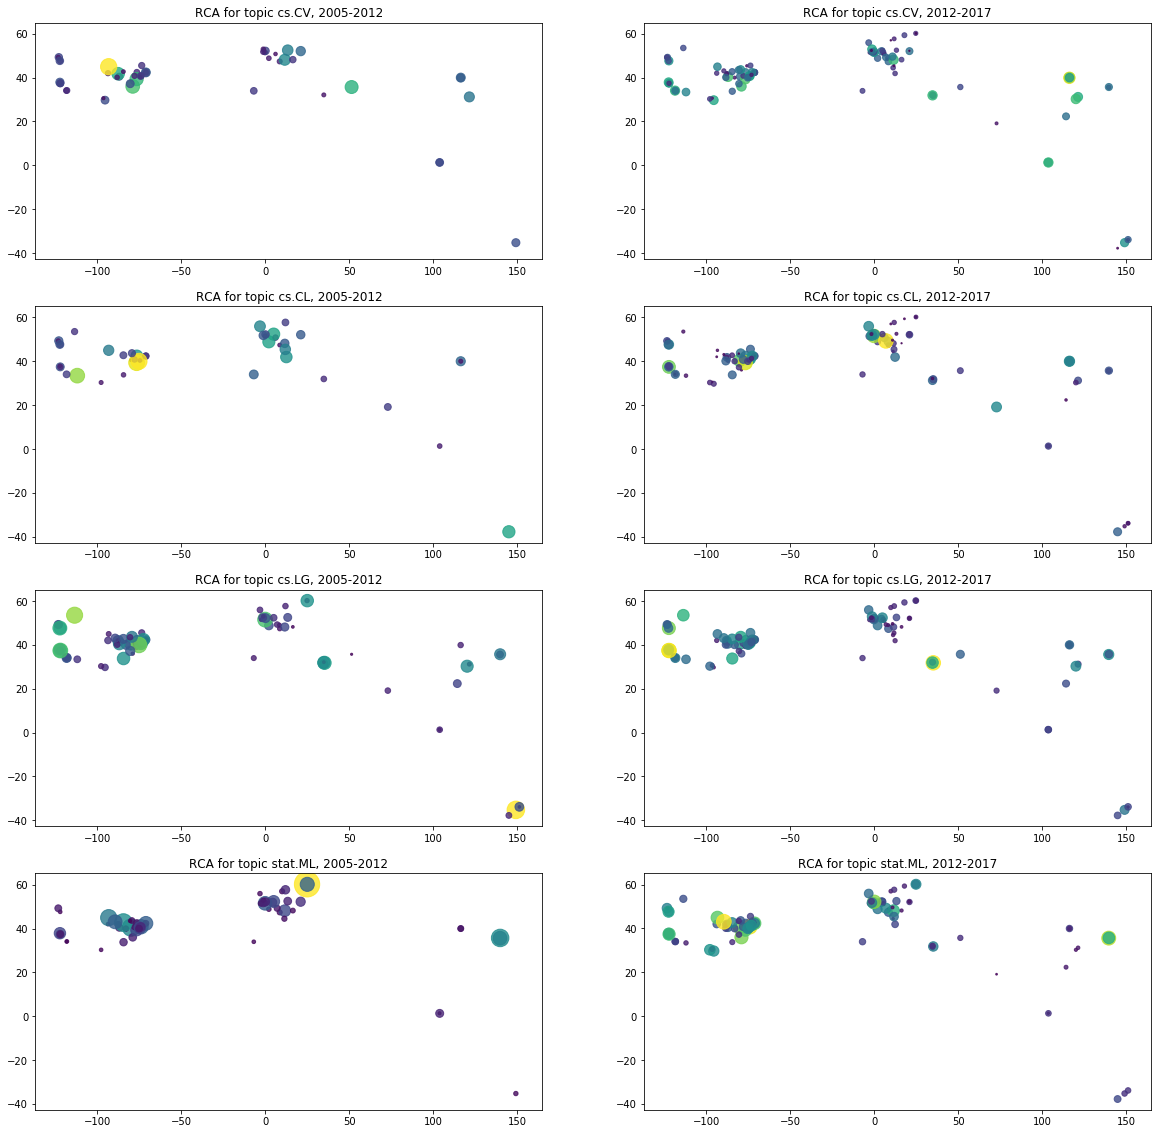

In [22]:
#Map this as a set of scatters.

institute_geo = papers_selected.drop_duplicates('institute')[['institute','lat','lon']]

rca_papers_averaged_wide_geo = pd.merge(rca_papers_averaged_wide,institute_geo,
                                       left_on='institute',right_on='institute')


fig,ax = plt.subplots(nrows=4,ncols=2,figsize=(20,20))

for num,x in enumerate(topics_sorted):
    subset = rca_papers_averaged_wide_geo.loc[rca_papers_averaged_wide_geo.variable==x,:]
    
    #First plot
    ax[num,0].scatter(subset['lon'],subset['lat'],s=50*subset['2005_12'],alpha=0.8,c=subset['2005_12'])
    ax[num,0].set_title("RCA for topic {top}, 2005-2012".format(top=x))
    
    
    #Second plot
    ax[num,1].scatter(subset['lon'],subset['lat'],s=50*subset['2012_17'],alpha=0.8,c=subset['2012_17'])
    ax[num,1].set_title("RCA for topic {top}, 2012-2017".format(top=x))
    
    



In [23]:
#Load the grid data
with open(ext_data+'/grid/grid.json','r') as infile:
    grid = json.load(infile)['institutes']

country_continents = pd.read_csv(ext_data+'/country_continent.csv')
country_continents.rename(columns={'iso 3166 country':'country',
                                  'continent code':'continent'},inplace=True)

In [24]:
grid_has_name = [x for x in grid if 'name' in x.keys()]

top_cs_discs = pd.concat([
    pd.DataFrame({'name':x['name'].lower(),
                 'city':x['addresses'][0]['city'],
                 'country':x['addresses'][0]['country_code']},index=[0])
                          for x in grid_has_name if x['name'].lower() 
    in set(rca_papers_averaged_wide.institute)]).reset_index(drop=True)

In [25]:
rca_country = pd.merge(pd.merge(rca_papers_averaged_wide,
                       top_cs_discs,left_on='institute',
                       right_on='name').drop('name',axis=1),
                       country_continents,left_on='country',right_on='country')

rca_country.fillna('AM',inplace=True)

In [26]:
set(rca_country.continent)

color_lookup = {'AF':'grey','AM':'blue','AS':'green','EU':'orange','OC':'red'}


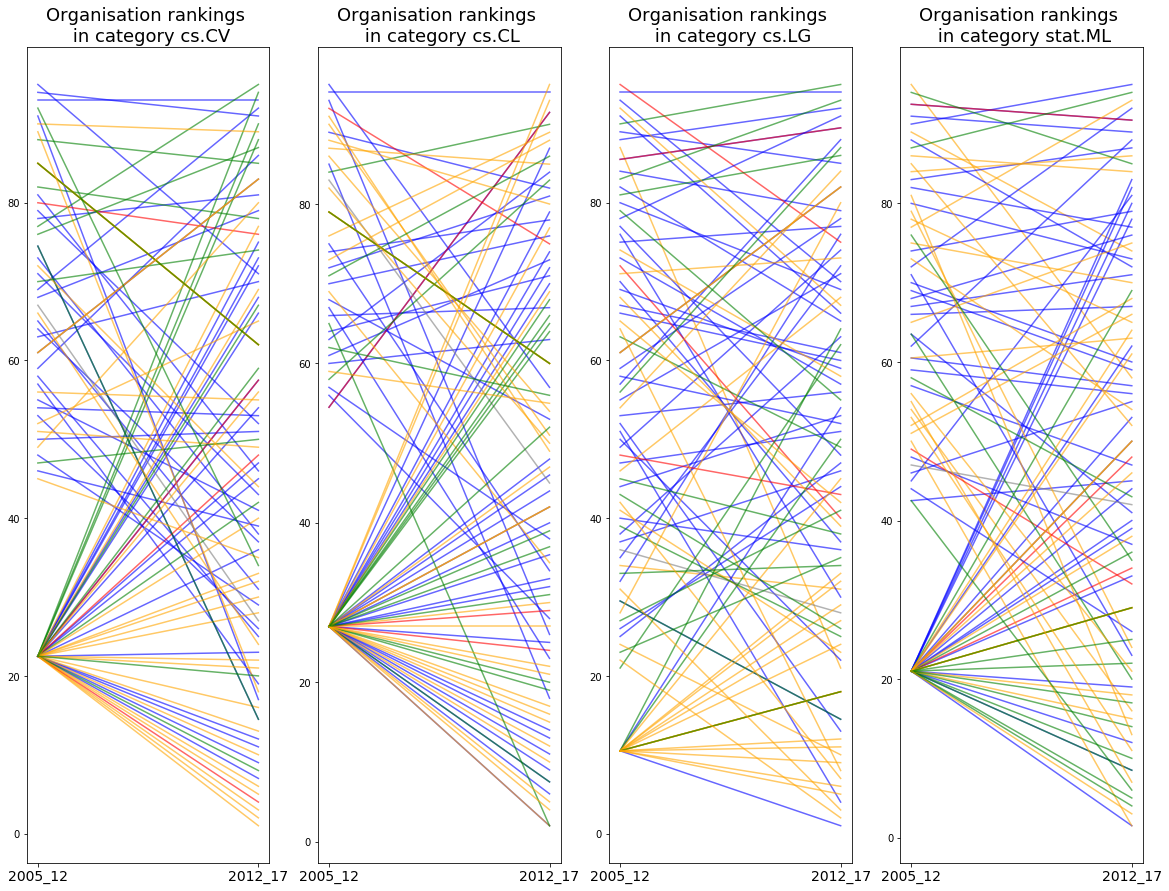

In [27]:
#I want to turn this into a bump chart.
#How will it work?

fig,ax= plt.subplots(ncols=4,figsize=(20,15))

for num,top in enumerate(topics_sorted):

    subset = rca_country.loc[rca_country.variable==top,:].reset_index(drop=True)

    rank_1 = subset['2005_12'].rank()
    rank_2 = subset['2012_17'].rank()

    for x in np.arange(0,len(rank_1)):
        ax[num].plot([rank_1[x],rank_2[x]],alpha=0.6,color=color_lookup[subset.loc[x,'continent']])
        
    ax[num].set_title('Organisation rankings \n in category {top}'.format(top=top),size=18)
    ax[num].set_xticks([0,1])
    ax[num].set_xticklabels(['2005_12','2012_17'],fontsize=14)
    
    #ax[num].legend(labels=color_lookup.keys())

plt.savefig(fig_path+'/bump_chart.pdf')




# Load data for CIA analysis

Actions

* Process abstracts: Tokenise, bigramise
* Track DL trends
* Identify policy worries


In [31]:
#Load data
arxiv_labelled = pd.read_csv(ext_data+'/arxiv_papers_with_label.csv')

In [32]:
#Imports

In [33]:
#Sentiment analysis

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from gensim import models, corpora
from nltk.corpus import stopwords
import string

sid = SentimentIntensityAnalyzer()
stopwords = stopwords.words('English')

symbols = "|".join([x for x in string.punctuation])

/usr/local/lib/python3.5/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "
/usr/local/lib/python3.5/site-packages/gensim/utils.py:1015: UserWarning: Pattern library is not installed, lemmatization won't be available.
  warnings.warn("Pattern library is not installed, lemmatization won't be available.")


In [34]:
def pre_process_text(text):
    '''
    Function to pre-process text - need to turn this into a utility one of these days! 
    
    '''
    cleaned = re.sub("\n"," ",str(text).lower())
    cleaned_no_signs = re.sub(r'[{x}]'.format(x=symbols),'',cleaned)
    
    
    tokenised = cleaned_no_signs.split(" ")
    no_sws = [x for x in tokenised if x not in stopwords and len(x)>0]
    
    return(no_sws)
    

In [35]:
#Tokenise the abstract text

arxiv_tokenised = [pre_process_text(x) for x in arxiv_labelled.summary]

## Topic modelling

In [36]:
#Phrases transforms the tokens into phrases

#Trains phraaes
phrases = models.Phrases(arxiv_tokenised)

#Tranforms into bigrams
bigram = models.phrases.Phraser(phrases)

In [37]:
new_corpus = bigram[arxiv_tokenised]

dictionary = corpora.Dictionary(new_corpus)

#Remove tokens that appear in less than 5 docs
dictionary.filter_extremes(no_below=5)

#Create BOW
corpus_bow = [dictionary.doc2bow(x) for x in new_corpus]

In [39]:
?models.LdaMulticore

In [48]:
#Model container
#model_cont = []

#Loop
for x in [200,300]:
    print(x)
    #Train model
    mod = models.LdaModel(corpus_bow,num_topics=x,iterations=100,passes=5,
        id2word=dictionary)
    
    model_cont.append([x,mod])


200
300


In [58]:
with open(mod_path+'/initial_models.p','wb') as outfile:
    pickle.dump(model_cont,outfile)

## Sentiment analysis

In [598]:
%%time

#Extract the polarity scores from articles

arxiv_sentiment = [sid.polarity_scores(" ".join(x)) for x in arxiv_tokenised]

CPU times: user 16min 2s, sys: 3.13 s, total: 16min 5s
Wall time: 19min 8s


In [614]:
arxiv_sent = pd.concat([pd.DataFrame([x['neg'] for x in arxiv_sentiment]),
                       arxiv_labelled],axis=1)

arxiv_sent.rename(columns={0:'negativity'},inplace=True)

In [621]:
neg_ranked = arxiv_sent.drop_duplicates('pid').loc[arxiv_sent.is_Deep_learning==1,:].sort_values(
    'negativity',ascending=False)[['negativity','summary']].reset_index(drop=True)

In [636]:
for n in np.arange(0,len(neg_ranked[:30])):
    print(n)
    print(neg_ranked['summary'][n])
    print("\n")

0
From only positive (P) and unlabeled (U) data, a binary classifier could be
trained with PU learning. Unbiased PU learning that is based on unbiased risk
estimators is now state of the art. However, if its model is very flexible, its
empirical risk on training data will go negative, and we will suffer from
overfitting seriously. In this paper, we propose a novel non-negative risk
estimator for PU learning. When being minimized, it is more robust against
overfitting, and thus we are able to train very flexible models given limited P
data. Moreover, we analyze the bias, consistency and mean-squared-error
reduction of the proposed risk estimator as well as the estimation error of the
corresponding risk minimizer. Experiments show that the non-negative risk
estimator outperforms unbiased counterparts when they disagree.


1
Some recent works revealed that deep neural networks (DNNs) are vulnerable to
so-called adversarial attacks where input examples are intentionally perturbed
to fool D